# Algorithmic Fairness Coursework

This notebook explores fairness in Stochastic Variational Gaussian Processes (SVGP).

## Setup

#### Installing necessary packages and data

In [1]:
!pip install 'aif360[LFR]' fairlearn gpflow

     |████████████████████████████████| 175 kB 7.2 MB/s 
     |████████████████████████████████| 177 kB 64.9 MB/s 
     |████████████████████████████████| 287 kB 63.4 MB/s 
     |████████████████████████████████| 462 kB 58.3 MB/s 
     |████████████████████████████████| 564 kB 58.3 MB/s 
  Created wheel for memory-profiler: filename=memory_profiler-0.60.0-py3-none-any.whl size=31284 sha256=accb430078b5bbfdde779b9c40e989c55406c49d77abec49c9e27714878a5c13
  Stored in directory: /root/.cache/pip/wheels/67/2b/fb/326e30d638c538e69a5eb0aa47f4223d979f502bbdb403950f
Successfully built memory-profiler


In [2]:
cd /usr/local/lib/python3.7/dist-packages/aif360/data/raw/adult

/usr/local/lib/python3.7/dist-packages/aif360/data/raw/adult


In [3]:
!wget https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data
!wget https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.names
!wget https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.test

--2022-03-01 09:14:29--  https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3974305 (3.8M) [application/x-httpd-php]
Saving to: ‘adult.data’

adult.data          100%[===================>]   3.79M  13.1MB/s    in 0.3s    

2022-03-01 09:14:29 (13.1 MB/s) - ‘adult.data’ saved [3974305/3974305]

--2022-03-01 09:14:29--  https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.names
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5229 (5.1K) [application/x-httpd-php]
Saving to: ‘adult.names’

adult.names         100%[===================>]   5.11K  --.-KB/s    in 0s      

2022-

In [4]:
cd /usr/local/lib/python3.7/dist-packages/aif360/data/raw/compas

/usr/local/lib/python3.7/dist-packages/aif360/data/raw/compas


In [5]:
!wget https://raw.githubusercontent.com/propublica/compas-analysis/master/compas-scores-two-years.csv

--2022-03-01 09:14:30--  https://raw.githubusercontent.com/propublica/compas-analysis/master/compas-scores-two-years.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2546489 (2.4M) [text/plain]
Saving to: ‘compas-scores-two-years.csv’

compas-scores-two-y 100%[===================>]   2.43M  --.-KB/s    in 0.04s   

2022-03-01 09:14:31 (62.3 MB/s) - ‘compas-scores-two-years.csv’ saved [2546489/2546489]



In [98]:
import numpy as np
import tensorflow as tf
#from tensorflow import keras
import time
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline

from sklearn import datasets
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.metrics import accuracy_score, make_scorer
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import cross_val_score, cross_validate, train_test_split

from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.utils.validation import check_X_y, check_array, check_is_fitted
from sklearn.utils.multiclass import unique_labels



import copy


from aif360.datasets import AdultDataset
from aif360.algorithms.preprocessing.optim_preproc_helpers.data_preproc_functions import load_preproc_data_adult, load_preproc_data_compas
from aif360.metrics import ClassificationMetric
from aif360.sklearn.metrics import equal_opportunity_difference
from aif360.sklearn.datasets import standardize_dataset
from aif360.sklearn.preprocessing import Reweighing

import gpflow

from gpflow.utilities import print_summary, set_trainable
from gpflow.ci_utils import ci_niter
from gpflow.models import SVGP
from gpflow import base

import warnings
warnings.filterwarnings("ignore")

np.random.seed(0)
tf.random.set_seed(123)

#### Datasets

In [7]:
def load_adult():

    adult_dataset = load_preproc_data_adult(['sex'])

    #train, test = dataset_orig.split([0.7], shuffle=True, seed=3)
    #print("training data size", train.features.shape)
    #print("dataset feature names", train.feature_names)

    #data_preprocessing = Pipeline([("standardiser", StandardScaler()),
                                #("minmaxscaler", MinMaxScaler()),
                                    # ]
                                    # )


    adult_income_data, adult_dict = adult_dataset.convert_to_dataframe()

    X, y = standardize_dataset(df=adult_income_data, prot_attr='sex', target='Income Binary')

    return train_test_split(
        X,
        y,
        test_size=0.30,
        random_state=42
        )

def load_compas():

    compas_dataset = load_preproc_data_compas(['race'])

    #train, test = dataset_orig.split([0.7], shuffle=True, seed=3)
    #print("training data size", train.features.shape)
    #print("dataset feature names", train.feature_names)

    #data_preprocessing = Pipeline([("standardiser", StandardScaler()),
                                #("minmaxscaler", MinMaxScaler()),
                                    # ]
                                    # )


    compas_data, compas_dict = compas_dataset.convert_to_dataframe()

    print(compas_dataset.feature_names)

    X, y = standardize_dataset(df=compas_data, prot_attr=['race'], target='two_year_recid')

    return train_test_split(
        X,
        y,
        test_size=0.30,
        random_state=42
        )


#### Setting up the model

In [8]:
class FairSVGP(SVGP):

    def __init__(
        self,
        kernel,
        likelihood,
        inducing_variable,
        *,
        mean_function=None,
        num_latent_gps: int = 1,
        q_diag: bool = False,
        q_mu=None,
        q_sqrt=None,
        whiten: bool = True,
        num_data=None,
        sample_weights=None,
        ):
        super().__init__(kernel, likelihood, inducing_variable, mean_function=mean_function, num_latent_gps=num_latent_gps, q_diag=q_diag, q_mu=q_mu, q_sqrt=q_sqrt, whiten=whiten, num_data=num_data)
        self.sample_weights = sample_weights

    def elbo(self, data) -> tf.Tensor:
        """
        This gives a variational bound (the evidence lower bound or ELBO) on
        the log marginal likelihood of the model.
        """
        X, Y, sample_weights = data
        kl = self.prior_kl()
        f_mean, f_var = self.predict_f(X, full_cov=False, full_output_cov=False)
        var_exp = self.likelihood.variational_expectations(f_mean, f_var, Y)
        if self.num_data is not None:
            num_data = tf.cast(self.num_data, kl.dtype)
            minibatch_size = tf.cast(tf.shape(X)[0], kl.dtype)
            scale = num_data / minibatch_size
        else:
            scale = tf.cast(1.0, kl.dtype)
        return tf.reduce_sum(var_exp*sample_weights) * scale - kl





In [13]:
class SVGP_binary_classifier(ClassifierMixin, BaseEstimator):
    """ A binary classifier that uses SVGP (Hensman, 2013).

    Parameters
    ----------
    M : int, default=100
        The number of inducing points to be used (comuptation scales as O(M^3)).

    Attributes
    ----------
    X_ : ndarray, shape (n_samples, n_features)
        The input passed during :meth:`fit`.
    y_ : ndarray, shape (n_samples,)
        The labels passed during :meth:`fit`.
    classes_ : ndarray, shape (n_classes,)
        The classes seen at :meth:`fit`.
    """
    def __init__(self, M=100):
        self.M = M

        self.elbo_training_log = []
        self.fairness_log = []
        

    def run_adam(self, model, iterations, training_data, minibatch_size):
        """
        Utility function running the Adam optimizer

        :param model: GPflow model
        :param interations: number of iterations
        """
        # Create an Adam Optimizer action

        train_dataset = tf.data.Dataset.from_tensor_slices(training_data).repeat().shuffle(self.N)

        logf = []
        
        train_iter = iter(train_dataset.batch(minibatch_size))

        training_loss = model.training_loss_closure(train_iter, compile=True)
        optimizer = tf.optimizers.Adam()

        @tf.function
        def optimization_step():
            optimizer.minimize(training_loss, model.trainable_variables)

        for step in range(iterations):
            optimization_step()
            if step % 10 == 0:
                elbo = -training_loss().numpy()
                logf.append(elbo/minibatch_size)
        return logf    


    def fit(self,
            X,
            y,
            minibatch_size=130,
            total_iterations=10000,
            show_training_curve=False,
            show_training_summary=False,
            robustmax_epsilon=0.001,
            sample_weights=None,
            reweighting_strength=1,
            q_mu_prior=None,
        ):
        """Fits the SVGP classifier to data.

        Parameters
        ----------
        X : array-like, shape (n_samples, n_features)
            The training input samples.
        y : array-like, shape (n_samples,)
            The target values. An array of int.
        minibatch_size : int
        total_iterations : int
        q_mu_prior: None for a balanced prior, "ones" for a prior
                    that places certainty on the target label = 1 for all
                    samples, "zeros" for target label = 0 for all samples.

        Returns
        -------
        self : object
            Returns self.
        """
        # Check that X and y have correct shape
        X, y = check_X_y(X, y)
        # Store the classes seen during fit
        self.classes_ = unique_labels(y)

        self.X_ = X
        self.y_ = y
        self.N = len(y)
        self.C = len(self.classes_)

        if sample_weights is None:
            sample_weights = np.ones(shape=(self.N,))
        else:
            assert len(sample_weights) == self.N

        sample_weights = np.array([(weight-1)*reweighting_strength+1 for weight in sample_weights])


        kernel_multi = gpflow.kernels.Matern52() + gpflow.kernels.White(variance=0.01)

        # Robustmax Multiclass Likelihood
        
        invlink = gpflow.likelihoods.RobustMax(
            self.C,
            epsilon=robustmax_epsilon
            )  # Robustmax inverse link function

        likelihood_multi = gpflow.likelihoods.MultiClass(
            self.C,
            invlink=invlink
            )  # Multiclass likelihood

        Z = X[:self.M].copy()  # inducing inputs

        # Defining the prior for q_mu:
        if q_mu_prior is not None:
            if q_mu_prior == "ones":
                q_mu = np.zeros(shape=[self.M, 2])
                q_mu[:,1]=1
            elif q_mu_prior == "zeros":
                q_mu = np.zeros(shape=[self.M, 2])
                q_mu[:,0]=1
            else:
                q_mu = q_mu_prior
        else:
            q_mu = None

        
        # Instantiating the model
        self.m = FairSVGP(
            kernel=kernel_multi,
            likelihood=likelihood_multi,
            inducing_variable=Z,
            num_latent_gps=self.C,
            whiten=True,
            q_diag=True,
            q_mu=q_mu,
            sample_weights=sample_weights
        )

        # Setting trainable parameters
        set_trainable(self.m.kernel.kernels[0].variance, False)
        set_trainable(self.m.inducing_variable, False)


        self.mb_size = minibatch_size
        training_data = (X, y, sample_weights)
        maxiter = ci_niter(total_iterations)
        self.elbo_training_log = self.run_adam(
            self.m,
            maxiter,
            training_data,
            self.mb_size,
            )
        
        if show_training_curve==True:
            plt.plot(np.linspace(0, total_iterations, len(self.elbo_training_log)), self.elbo_training_log)
            plt.xlabel("Iteration")
            plt.ylabel("ELBO per data point")
            plt.title("Training curve")
            plt.show()

        if show_training_summary==True:
            print_summary(self.m, fmt="notebook")

        # Return the classifier
        return self


    def predict(self, X_test):
        """ A reference implementation of a prediction for a classifier.
        Parameters
        ----------
        X : array-like, shape (n_samples, n_features)
            The input samples.
        Returns
        -------
        y : ndarray, shape (n_samples,)
            The label for each sample is the label of the closest sample
            seen during fit.
        """
        # Check is fit had been called
        check_is_fitted(self, ['X_', 'y_'])

        # Input validation
        X_test = check_array(X_test)

        mu, _ = self.m.predict_y(X_test)
        predictions = []
        for probs in mu:
            prediction = np.argmax(probs)
            predictions.append(prediction)
        return predictions


#### Metrics

In [67]:
from fairlearn.metrics import true_positive_rate


# Make TPR difference function
def tpr_differ(y_test, predictions, pos_label=1):
    unpriv_test = []
    priv_test = []
    unpriv_pred = []
    priv_pred = []
    for i, index in enumerate(list(y_test.index)):
        if index[1]==0:
            unpriv_test.append(y_test[index])
            unpriv_pred.append(predictions[i])
        if index[1]==1:
            priv_test.append(y_test[index])
            priv_pred.append(predictions[i])
    tpr_priv = true_positive_rate(priv_test, priv_pred, pos_label=pos_label)
    tpr_unpriv = true_positive_rate(unpriv_test, unpriv_pred, pos_label=pos_label)
    return tpr_unpriv-tpr_priv

def positives_ratio(y_test, predictions, pos_label=1):
    """tells the ratio of positive predictions to positives in y_test

    Args:
        y_test (_type_): _description_
        predictions (_type_): _description_

    Returns:
        float: ratio of positives
    """
    test_positives = list(y_test).count(pos_label)
    pred_positives = list(predictions).count(pos_label)
    return pred_positives/test_positives

def print_scores(y_test, predictions, pos_label=1, print_score=True):
    """prints accuracy, TPR difference and positives ratio for a set of predictions

    Args:
        y_test (array)
        predictions (array)
        pos_label (int, optional): label of desireable class. Defaults to 1.
    """
    tpr = tpr_differ(y_test, predictions, pos_label)
    acc = accuracy_score(y_test, predictions)
    pos = positives_ratio(y_test, predictions, pos_label)
    
    if print_score:
        print("Equality of opportunity difference:", tpr)
        print("Accuracy score:", acc)
        print("Positives Ratio:", pos)

    return tpr, acc, pos


#### Load datasets

For adult dataset:

privileged group: "sex"=1 (male)

desireable label: "Income_binary"=1 (> 50k salary)



For COMPAS dataset:

privileged group: "race"=1 (caucasian)

desireable label: "two_year_recid"=0 (did not reoffend)

In [11]:
X_train_adult, X_test_adult, y_train_adult, y_test_adult = load_adult()
X_train_compas, X_test_compas, y_train_compas, y_test_compas = load_compas()


print("Number of training datapoints in adult dataset:", len(X_train_adult))
print("Number of features in adult dataset", len(X_train_adult.columns))

print("Number of training datapoints in COMPAS dataset:", len(X_train_compas))
print("Number of features in COMPAS dataset", len(X_train_compas.columns))

['sex', 'race', 'age_cat=25 to 45', 'age_cat=Greater than 45', 'age_cat=Less than 25', 'priors_count=0', 'priors_count=1 to 3', 'priors_count=More than 3', 'c_charge_degree=F', 'c_charge_degree=M']
Number of training datapoints in adult dataset: 34189
Number of features in adult dataset 18
Number of training datapoints in COMPAS dataset: 3694
Number of features in COMPAS dataset 10


#### Train Plain SVGP models

##### Adult Dataset

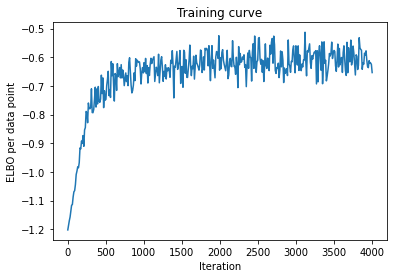

name,class,transform,prior,trainable,shape,dtype,value
FairSVGP.kernel.kernels[0].variance,Parameter,Softplus,,False,(),float64,1.0
FairSVGP.kernel.kernels[0].lengthscales,Parameter,Softplus,,True,(),float64,1.6125805749382334
FairSVGP.kernel.kernels[1].variance,Parameter,Softplus,,True,(),float64,0.004704775439685573
FairSVGP.likelihood.invlink.epsilon,Parameter,Sigmoid,Beta,False,(),float64,0.10000000000000002
FairSVGP.inducing_variable.Z,Parameter,Identity,,False,"(400, 18)",float64,"[[1., 1., 0...."
FairSVGP.q_mu,Parameter,Identity,,True,"(400, 2)",float64,"[[1.13982527e+00, -1.13982527e+00..."
FairSVGP.q_sqrt,Parameter,Softplus,,True,"(400, 2)",float64,"[[0.33769091, 0.33769091..."


Scores for plain SVGP model on adult dataset:
Equality of opportunity difference: -0.4473413379073756
Accuracy score: 0.8070019791169044
Positives Ratio: 0.5894736842105263


In [70]:
plain_SVGP_adult = SVGP_binary_classifier(400)
plain_SVGP_adult.fit(
    X_train_adult,
    y_train_adult,
    minibatch_size=500,
    total_iterations=4000,
    show_training_curve=True,
    sample_weights=None,
    show_training_summary=True,
    robustmax_epsilon=0.1)
y_pred = plain_SVGP_adult.predict(X_test_adult)

print("Scores for plain SVGP model on adult dataset:")
print_scores(y_test_adult, y_pred);

As we can see from the metrics above, the model is biased towards males, indicated by the large negative value for the EOP metric. Furthermore, the model is not classifying as many samples as positive (salary of >50k) as there are positive labels in the test set. Ideally, our model should predict as many positives as there are in the test set to meet a certain quota (eg. hiring).

Seeing how this compares to the metrics of a completely untrained model, of entirely negative and positive predictions:

In [69]:
print("Scores for fully negative predictions on adult dataset:")
print_scores(y_test_adult, np.zeros(len(y_test_adult)))

print("Scores for fully positive predictions on adult dataset:")
print_scores(y_test_adult, np.ones(len(y_test_adult)));

Scores for fully negative predictions on adult dataset:
Equality of opportunity difference: 0.0
Accuracy score: 0.766600696103187
Positives Ratio: 0.0
Scores for fully positive predictions on adult dataset:
Equality of opportunity difference: 0.0
Accuracy score: 0.23339930389681293
Positives Ratio: 4.284502923976608


This shows that 76.7% of the samples have a salary of less than 50k, and that the SVGP model makes an improvement to the accuracy of predictions (as is indicated by the training curve).

##### COMPAS dataset

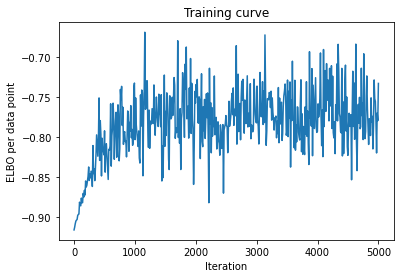

name,class,transform,prior,trainable,shape,dtype,value
FairSVGP.kernel.kernels[0].variance,Parameter,Softplus,,False,(),float64,1.0
FairSVGP.kernel.kernels[0].lengthscales,Parameter,Softplus,,True,(),float64,1.742150258954218
FairSVGP.kernel.kernels[1].variance,Parameter,Softplus,,True,(),float64,0.0009726452295022131
FairSVGP.likelihood.invlink.epsilon,Parameter,Sigmoid,Beta,False,(),float64,0.2
FairSVGP.inducing_variable.Z,Parameter,Identity,,False,"(200, 10)",float64,"[[0., 0., 0...."
FairSVGP.q_mu,Parameter,Identity,,True,"(200, 2)",float64,"[[4.69829177e-01, -4.69829177e-01..."
FairSVGP.q_sqrt,Parameter,Softplus,,True,"(200, 2)",float64,"[[0.41814636, 0.41814635..."


Scores for plain SVGP model on COMPAS dataset:
Equality of opportunity difference: -0.20688607594936703
Accuracy score: 0.6521464646464646
Positives Ratio: 1.1566548881036514


In [48]:
plain_SVGP_compas = SVGP_binary_classifier(200)
plain_SVGP_compas.fit(
    X_train_compas,
    y_train_compas,
    minibatch_size=200,
    total_iterations=5000,
    show_training_curve=True,
    sample_weights=None,
    show_training_summary=True,
    robustmax_epsilon=0.2)
y_pred = plain_SVGP_compas.predict(X_test_compas)

print("Scores for plain SVGP model on COMPAS dataset:")
print_scores(y_test_compas, y_pred, pos_label=0)

N.B. 0 (no reoffence) is the desireable label. The EOP difference shows that the model is biased against non-Caucasian samples. The model also slightly underestimates the number number of samples that will reoffend.

In [24]:
print("Scores for fully negative predictions on COMPAS dataset:")
print_scores(y_test_compas, np.ones(len(y_test_compas)), pos_label=0)

print("Scores for fully positive predictions on COMPAS dataset:")
print_scores(y_test_compas, np.zeros(len(y_test_compas)), pos_label=0)

Scores for fully negative predictions on COMPAS dataset:
Equality of opportunity difference: 0.0
Accuracy score: 0.4640151515151515
Positives Ratio: 0.0
Scores for fully positive predictions on COMPAS dataset:
Equality of opportunity difference: 0.0
Accuracy score: 0.5359848484848485
Positives Ratio: 1.8657243816254416


We can see that the model makes an improvement on the accuracy of the trivial untrained predictor.

## Task 1: Effect of regularisation on fairness and accuracy

##### Adult Dataset

In [49]:
epsilons_adult = np.linspace(0.15, 0.34, 8)
epsilons_adult = [[epsilon] for epsilon in epsilons_adult]

scoring_metrics = {"accuracy": "accuracy", "equal_opportunity_difference": make_scorer(tpr_differ), "positives_ratio": make_scorer(positives_ratio)}

score_log_adult = []

with tf.device('/device:GPU:0'):  # Using GPU for supposedly faster computation.
    for epsilon in epsilons_adult:
        svgpclass = SVGP_binary_classifier(400)
        scores = cross_validate(
            svgpclass,
            X_train_adult,
            y_train_adult,
            scoring=scoring_metrics,
            cv=5,
            fit_params={"robustmax_epsilon": epsilon, "total_iterations":4000, "minibatch_size":500})
        print(
            "RobustMax epsilon:", epsilon,
            "\n", "average accuracy:", np.mean(scores["test_accuracy"]),
            " | Average equal opportunity difference:",np.mean(scores["test_equal_opportunity_difference"]),
            " | Average positives ratio:", np.mean(scores["test_positives_ratio"])
            )
        score_log_adult.append(scores)


RobustMax epsilon: [0.1] 
 average accuracy: 0.8025095929735248  | Average equal opportunity difference: -0.4428095212745797  | Average positives ratio: 0.5669535657933141
RobustMax epsilon: [0.13833333333333334] 
 average accuracy: 0.8025095929735248  | Average equal opportunity difference: -0.4428095212745797  | Average positives ratio: 0.5669535657933141
RobustMax epsilon: [0.1766666666666667] 
 average accuracy: 0.8025095929735248  | Average equal opportunity difference: -0.4428095212745797  | Average positives ratio: 0.5669535657933141
RobustMax epsilon: [0.21500000000000002] 
 average accuracy: 0.8008130322326563  | Average equal opportunity difference: -0.42725552379459764  | Average positives ratio: 0.5476004567562842
RobustMax epsilon: [0.25333333333333335] 
 average accuracy: 0.8001987790484847  | Average equal opportunity difference: -0.4163378708800433  | Average positives ratio: 0.5317504870043182
RobustMax epsilon: [0.2916666666666667] 
 average accuracy: 0.79139482992233

##### Compas Dataset

In [50]:
epsilons_compas = np.linspace(0.2, 0.495, 8)
epsilons_compas = [[epsilon] for epsilon in epsilons_compas]

score_log_compas = []

with tf.device('/device:GPU:0'):  # Using GPU for supposedly faster computation.
    for epsilon in epsilons_compas:
        svgpclass = SVGP_binary_classifier(200)
        scores = cross_validate(
            svgpclass,
            X_train_compas,
            y_train_compas,
            scoring=scoring_metrics,
            cv=5,
            fit_params={"robustmax_epsilon": epsilon, "total_iterations":4000, "minibatch_size":200})
        print(
            "RobustMax epsilon:", epsilon,
            "\n", "average accuracy:", np.mean(scores["test_accuracy"]),
            " | Average equal opportunity difference:",-np.mean(scores["test_equal_opportunity_difference"]),
            " | Average positives ratio:", np.mean(scores["test_positives_ratio"])
            )
        score_log_compas.append(scores)

RobustMax epsilon: [0.2] 
 average accuracy: 0.672714170984741  | Average equal opportunity difference: 0.2623306305540755  | Average positives ratio: 0.8323896848137535
RobustMax epsilon: [0.25] 
 average accuracy: 0.6705490830280427  | Average equal opportunity difference: 0.24741401180766953  | Average positives ratio: 0.8175325419566107
RobustMax epsilon: [0.3] 
 average accuracy: 0.6713613577272444  | Average equal opportunity difference: 0.24713429152794925  | Average positives ratio: 0.8123880474826034
RobustMax epsilon: [0.35] 
 average accuracy: 0.6689256337759588  | Average equal opportunity difference: 0.24559887406686495  | Average positives ratio: 0.7843585755218992
RobustMax epsilon: [0.4] 
 average accuracy: 0.6670308150984081  | Average equal opportunity difference: 0.27906577590036347  | Average positives ratio: 0.7597724109701187
RobustMax epsilon: [0.44999999999999996] 
 average accuracy: 0.6645928908544837  | Average equal opportunity difference: 0.32615472435599985

##### Plots

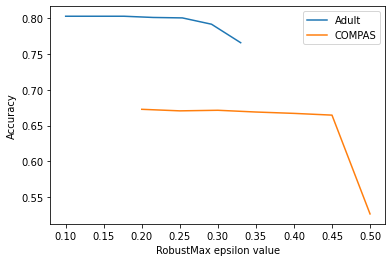

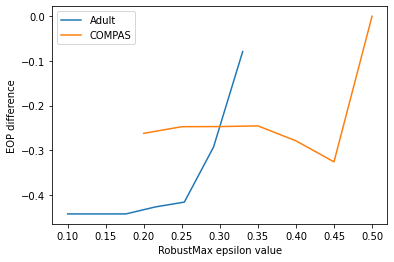

In [53]:
accuracies_adult = []
fairnesses_adult = []

accuracies_compas = []
fairnesses_compas = []

for score in score_log_adult:
    fairness = np.mean(score["test_equal_opportunity_difference"])
    accuracy = np.mean(score["test_accuracy"])
    accuracies_adult.append(accuracy)
    fairnesses_adult.append(fairness)

for score in score_log_compas:
    fairness = -np.mean(score["test_equal_opportunity_difference"])
    accuracy = np.mean(score["test_accuracy"])
    accuracies_compas.append(accuracy)
    fairnesses_compas.append(fairness)


plt.xlabel("RobustMax epsilon value")
plt.ylabel("Accuracy")
plt.plot(epsilons_adult, accuracies_adult, label="Adult")
plt.plot(epsilons_compas, accuracies_compas, label="COMPAS")
plt.legend()
plt.show()


plt.xlabel("RobustMax epsilon value")
plt.ylabel("EOP difference")
plt.plot(epsilons_adult, fairnesses_adult, label="Adult")
plt.plot(epsilons_compas, fairnesses_compas, label="COMPAS")
plt.legend()
plt.show()

## Task 2: Fairness model

Cross validation is not used for the remainder of this notebook due to large computation times.

In [80]:
rw_adult = Reweighing(["sex"])
# We obtain a set of weights for the training set, to use in scikit-learn.
_, reweights_adult = rw_adult.fit_transform(X_train_adult, y_train_adult)
reweights_adult = np.array(reweights_adult)


rw_compas = Reweighing(["race"])
# We obtain a set of weights for the training set, to use in scikit-learn.
_, reweights_compas = rw_compas.fit_transform(X_train_compas, y_train_compas)
reweights_compas = np.array(reweights_compas)

print(reweights_compas[:6])



[1.11894392 0.89418163 0.86346393 0.89418163 0.86346393 1.11894392]


In [ ]:
weighted_SVGP_adult = SVGP_binary_classifier(400)
weighted_SVGP_adult.fit(
    X_train_adult,
    y_train_adult,
    minibatch_size=500,
    total_iterations=6000,
    sample_weights=reweights_adult,
    )

y_pred = weighted_SVGP_adult.predict(X_test_adult)

print("Scores for plain SVGP model on adult dataset:")
print_scores(y_test_adult, y_pred);

In [86]:
sample_weights = np.array([(weight-1)*1.5+1 for weight in reweights_compas])

weighted_SVGP_compas = SVGP_binary_classifier(200)
weighted_SVGP_compas.fit(
    X_train_compas,
    y_train_compas,
    minibatch_size=200,
    total_iterations=6000,
    sample_weights=sample_weights,
    )

y_pred = weighted_SVGP_compas.predict(X_test_compas)

print("Scores for plain SVGP model on COMPAS dataset:")
print_scores(y_test_compas, y_pred, pos_label=0);

Scores for plain SVGP model on COMPAS dataset:
Equality of opportunity difference: -0.027898734177215223
Accuracy score: 0.6458333333333334
Positives Ratio: 1.0482921083627796


## Task 3: Fairness-Accuracy Trade-off

##### Adult Dataset

In [102]:
reweighting_strengths_adult = np.linspace(0, 1.5, 40)
reweighting_strengths_compas = np.linspace(0.3, 1.8, 40)


tpr_diff_adult_reweight = []
accuracies_adult_reweight = []
pos_ratios_adult_reweight = []

for reweighting_strength in reweighting_strengths_adult:
    sample_weights = np.array([(weight-1)*reweighting_strength+1 for weight in reweights_adult])

    weighted_SVGP_adult = SVGP_binary_classifier(400)
    weighted_SVGP_adult.fit(
        X_train_adult,
        y_train_adult,
        minibatch_size=500,
        total_iterations=6000,
        sample_weights=sample_weights,
        )

    y_pred = weighted_SVGP_adult.predict(X_test_adult)

    tpr, acc, pos = print_scores(y_test_adult, y_pred, print_score=False)

    tpr_diff_adult_reweight.append(tpr)
    accuracies_adult_reweight.append(acc)
    pos_ratios_adult_reweight.append(pos)


tpr_diff_compas_reweight = []
accuracies_compas_reweight = []
pos_ratios_compas_reweight = []

for reweighting_strength in reweighting_strengths_compas:
    sample_weights = np.array([(weight-1)*reweighting_strength+1 for weight in reweights_compas])

    weighted_SVGP_compas = SVGP_binary_classifier(400)
    weighted_SVGP_compas.fit(
        X_train_compas,
        y_train_compas,
        minibatch_size=500,
        total_iterations=6000,
        sample_weights=sample_weights,
        )

    y_pred = weighted_SVGP_compas.predict(X_test_compas)

    tpr, acc, pos = print_scores(y_test_compas, y_pred, pos_label=0, print_score=False)

    tpr_diff_compas_reweight.append(tpr)
    accuracies_compas_reweight.append(acc)
    pos_ratios_compas_reweight.append(pos)





[-0.4620926243567753, -0.4620926243567753, -0.45008576329331046, -0.4473413379073756, -0.4473413379073756, -0.4473413379073756, -0.4473413379073756, -0.4473413379073756, -0.4473413379073756, -0.4473413379073756, -0.4473413379073756, -0.4473413379073756, -0.4473413379073756, -0.4473413379073756, -0.4473413379073756, -0.37605420919450433, -0.2295195557291578, -0.2295195557291578, -0.2295195557291578, -0.03942054582816773, -0.03942054582816773, -0.03942054582816773, -0.03942054582816773, -0.03942054582816773, -0.03942054582816773, -0.02753935770935584, 0.005736800095103856, 0.005736800095103856, 0.005736800095103856, 0.005736800095103856, 0.005736800095103856, 0.1336956337143148, 0.1455768218331267, 0.1415858566988774, 0.1455768218331267, 0.1534670448176893, 0.1534670448176893, 0.1534670448176893, 0.1534670448176893, 0.17722942105531309]


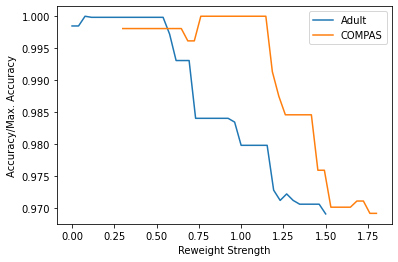

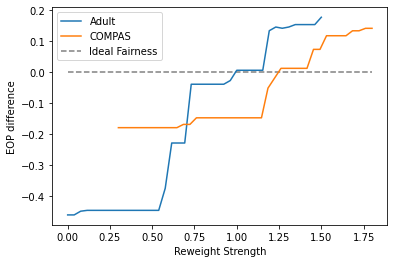

In [104]:
plt.figure()
plt.xlabel("Reweight Strength")
plt.ylabel("Accuracy/Max. Accuracy")
plt.plot(reweighting_strengths_adult, np.array(accuracies_adult_reweight)/max(accuracies_adult_reweight), label="Adult")
plt.plot(reweighting_strengths_compas, np.array(accuracies_compas_reweight)/max(accuracies_compas_reweight), label="COMPAS")
plt.legend()

plt.figure()
plt.xlabel("Reweight Strength")
plt.ylabel("EOP difference")
plt.plot(reweighting_strengths_adult, tpr_diff_adult_reweight, label="Adult")
plt.plot(reweighting_strengths_compas, tpr_diff_compas_reweight, label="COMPAS")
plt.hlines(0, 0, 1.8, "k", linestyles="dashed", label="Ideal Fairness", alpha=0.5)
plt.legend()


print(tpr_diff_adult_reweight)
